In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
    get_x_extras,
)
from rna_learn.model import (
    conv1d_classification_model,
    compile_classification_model,
)
from rna_learn.load import load_mrna_model, load_dataset

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
alphabet = ['A', 'T', 'G', 'C']
classes = ['psychrophilic', 'mesophilic', 'thermophilic']

model = conv1d_classification_model(
    alphabet_size=len(alphabet), 
    n_classes=len(classes),
    n_conv_1=10,
    n_filters_1=100, 
    kernel_size_1=58,
    l2_reg_1=0.,
    n_conv_2=10,
    n_filters_2=100, 
    kernel_size_2=40,
    l2_reg_2=0.,
    dropout=0.5,
)
compile_classification_model(
    model,
    learning_rate=1e-4,
    epsilon=1e-7
)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 4)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         23300     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         580100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 100)         580100    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 100)         580100    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 100)         580100    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 100)         580100

In [6]:
test_set_path = os.path.join(os.getcwd(), 'data/dataset_test.csv')

dataset_df = pd.read_csv(test_set_path)

sequences = dataset_df['sequence'].values
temperature_classes = dataset_df['temperature_range'].values

x_test = sequence_embedding(sequences, alphabet)
y_test = one_hot_encode_classes(temperature_classes, classes)

print(x_test.shape, y_test.shape)

(3700, 3483, 4) (3700, 3)


In [ ]:
model.evaluate(x_test, y_test, verbose=1)

In [8]:
%%time
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]

CPU times: user 2min 28s, sys: 1min, total: 3min 28s
Wall time: 46.7 s


In [9]:
def plot_confusion_matrix(labels, predictions, classes):
    conf = tf.math.confusion_matrix(labels, predictions).numpy()
    conf_sum = np.sum(conf, axis=1)
    conf_p = conf / conf_sum
    
    df_cm = pd.DataFrame(
        conf_p, 
        index=[f'{c}: {i}' for i, c in enumerate(classes)],
        columns=[f'{i}' for i, c in enumerate(classes)],
    )
    ax = sns.heatmap(df_cm, cmap="Purples", annot=True, fmt='.0%', cbar=False);
    ax.set_xlabel('Predictions');
    ax.set_ylabel('Labels');

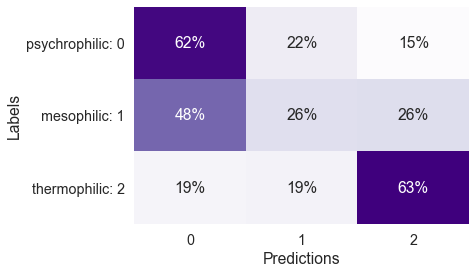

In [10]:
plot_confusion_matrix(labels, predictions, classes)